In [1]:
# !pip install -U matplotlib --quiet
# !pip install torch --quiet
# !pip install lightning --quiet

In [2]:
# !git clone https://github.com/QMCSoftware/QMCSoftware
# !cd QMCSoftware && git checkout qmctoolscl_integration
# !cd QMCSoftware && git pull
# !cd QMCSoftware && pip install -e .

# Operator learning kernel methods for 1 dimensional elliptic PDE

Here we will solve the PDE

$$\begin{cases} C_1 v^3 + C_2 \Delta v = u, & x \in [0,1] \\ v = 0, &x \in \partial [0,1]^d \end{cases}$$

where $\Delta$ is the Laplacian, $u$ is random and $v$ is the unknown PDE solution.    

In [175]:
# may need to Runtime > Restart session if loading for the first time
import torch
import qmcpy as qp
import pandas as pd
import numpy as np
import torch
import gpytorch
import lightning
import time
from collections import OrderedDict
import os
import glob
import warnings
from typing import List

In [176]:
assert torch.cuda.is_available() or torch.backends.mps.is_available()
DEVICE = "cuda" if torch.cuda.is_available() else "mps"

In [177]:
from matplotlib import pyplot,cm,colors,gridspec
pyplot.style.use('seaborn-v0_8-whitegrid')
LW = 3 # linewidth
LWTHIN = 0.01
COLORS = ["xkcd:"+color[:-1] for color in pd.read_csv("./xkcd_colors.txt",comment="#").iloc[:,0].tolist()]

## Reference Solution

We will randomly generate $v$ from
$$\exp\left(-\frac{1}{1-r^2}\right)\left[\sum_{p=1}^P a_p \sin(p \pi x)\right] 1_{x \in (0,1)}$$
where $r=2x-1$ and $(a_1,\dots,a_P) \sim \mathcal{U}[-\overline{B},\underline{B}]^P$. We will use auto-diff to find $u$.

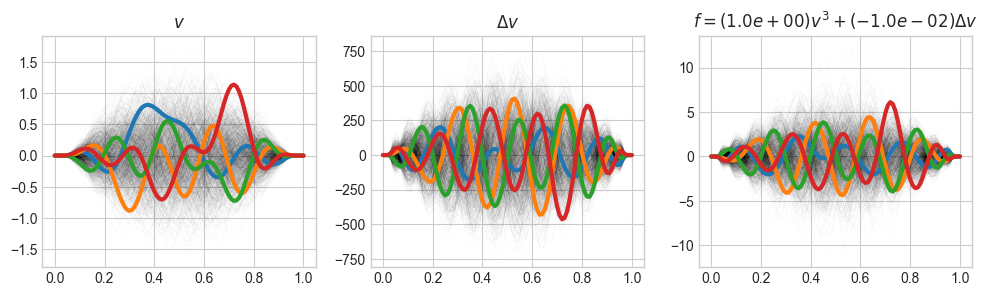

In [178]:
C1 = 1.
C2 = -1./100
def v(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    P = len(a)
    assert a.shape==(P,)
    y = torch.zeros_like(x)
    r = 2*x-1
    b = torch.abs(r)<1
    t1 = torch.exp(-1/(1-r[b]**2))
    t2 = (a[:,None]*torch.sin(torch.arange(1,P+1)[:,None]*torch.pi*x[None,b])).sum(0)
    y[b] = t1*t2
    return y
def v_laplace(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    xg = x.clone().requires_grad_()
    yg = v(xg,a)
    grad_outputs = torch.ones_like(x)
    ypg = torch.autograd.grad(yg,xg,grad_outputs,create_graph=True)[0]
    yppg = torch.autograd.grad(ypg,xg,grad_outputs,create_graph=True)[0]
    return yppg.detach()
def u(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    return C1*v(x,a)**3+C2*v_laplace(x,a)
R = 2**10
P = 10
B_low = -1.
B_high = 1.
dnb2 = qp.DigitalNetB2(P,seed=7,graycode=True)
unif_dnb2 = qp.Uniform(dnb2,lower_bound=B_low,upper_bound=B_high)
a = torch.from_numpy(unif_dnb2.gen_samples(R))
nxticks = 101
xticks = torch.linspace(0,1,nxticks,dtype=float)
vticks = torch.vstack([v(xticks,a=a[r]) for r in range(R)])
vlticks = torch.vstack([v_laplace(xticks,a=a[r]) for r in range(R)])
uticks = torch.vstack([u(xticks,a=a[r]) for r in range(R)])
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(12,3))
coloridxs = torch.arange(4)
ax[0].plot(xticks,vticks.T,color='k',linewidth=LWTHIN)
ax[1].plot(xticks,vlticks.T,color='k',linewidth=LWTHIN)
ax[2].plot(xticks,uticks.T,color='k',linewidth=LWTHIN)
ax[0].plot(xticks,vticks.T[:,coloridxs],linewidth=LW)
ax[1].plot(xticks,vlticks.T[:,coloridxs],linewidth=LW)
ax[2].plot(xticks,uticks.T[:,coloridxs],linewidth=LW)
ax[0].set_title(r"$v$")
ax[1].set_title(r"$\Delta v$")
ax[2].set_title(r"$f = (%.1e) v^3 + (%.1e) \Delta v$"%(C1,C2));

## PDE setup

In [179]:
llbetas = [ # derivative orders
    [ # interior
        torch.tensor([[0]],dtype=int), # v
        torch.tensor([[2]],dtype=int), # laplacian v
    ],
    [ # boundary
        torch.tensor([[0]],dtype=int) # v
    ]
]
llcs = [ # summand of derivatives coefficients
    [ # interior
        torch.ones(1,dtype=float), # v
        torch.ones(1,dtype=float) # laplacian v
    ],
    [ # boundary
        torch.ones(1,dtype=float) # v
    ]
]
xs = [xticks[:,None],torch.tensor([[0],[1]],dtype=float)]

## Kernel interpolant setup

In [180]:
noise = 1e-8
lattice = qp.Lattice(dimension=1,seed=7) # collocation points
#kernel = qp.KernelShiftInvar(dimension=1,lengthscales=1e-1,alpha=4,scale=1.,torchify=True) # kernel
kernel = qp.KernelGaussian(dimension=1,lengthscales=1e-3,scale=1.,torchify=True) # kernel
ki = qp.PDEGramMatrix(xs,kernel,llbetas,llcs,noise) # kernel interpolant

## Dataset Generation

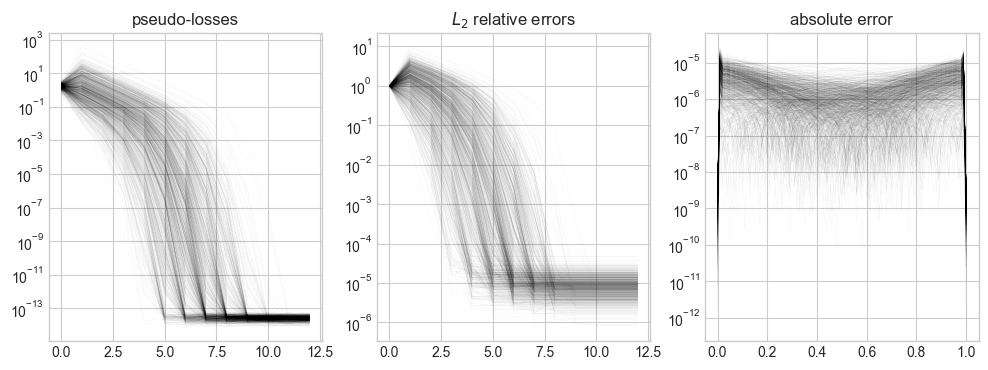

In [181]:
kvec = ki.get_new_left_full_gram_matrix(xticks[:,None])
def get_data(maxiter=10, tag="full", force_gen=False):
    fname = "./%s.%s.pt"%("oplearn_elliptic_pde_1d",tag)
    if os.path.exists(fname) and not force_gen:
        data = torch.load(fname)
        vopt = data["vopt"]
        losses_opt = data["losses_opt"]
        l2rerrs = data["l2rerrs"]
    else:
        vopt = torch.empty((R,maxiter+1,ki.length),dtype=float)
        losses_opt = torch.empty((R,maxiter+1),dtype=float)
        vhats = torch.empty((R,maxiter+1,nxticks),dtype=float)
        l2rerrs = torch.empty((R,maxiter+1),dtype=float)
        print("r from 0 to %d, l2 relative errors\n"%(R)+"~"*100)
        verbosity = R//8
        for r in range(R):
            if (r+1)%verbosity==0: print("r = %d: "%(r+1),end='',flush=True)
            def pde_lhs_r(ly_i, ly_b):
                v_i,v_laplace_i = ly_i
                v_b = ly_b[0]
                lhs_i = C1*v_i**3+C2*v_laplace_i
                lhs_b = v_b
                return lhs_i,lhs_b
            def pde_rhs_r(x_i, x_b):
                y_i = uticks[r]
                y_b = torch.zeros(len(x_b),dtype=float)
                return y_i,y_b
            y,losses_opt[r,:],rerrors_opt,times_opt,vopt[r,:,:] = ki.pde_opt_gauss_newton(
                pde_lhs = pde_lhs_r,
                pde_rhs = pde_rhs_r,
                maxiter = maxiter,
                solver = "CHOL",
                verbose = False)
            #coeffs = ki._solve(vopt[r,:,:].T)
            #vhats[r,:,:] = (kvec@coeffs).T
            l2rerrs[r,:] = torch.linalg.norm(vopt[r,:,:nxticks]-vticks[r],dim=1)/torch.linalg.norm(vticks[r])
            if (r+1)%verbosity==0:
                with np.printoptions(precision=1,threshold=8):
                    print(l2rerrs[r,:].numpy())
            data = {
                "vopt": vopt,
                "losses_opt": losses_opt,
                "l2rerrs": l2rerrs,}
        torch.save(data,fname)
    return vopt,losses_opt,l2rerrs
maxiter = 12
vopt,losses_opt,l2rerrs = get_data(maxiter=maxiter,tag="small",force_gen=False)
best_idxs = losses_opt.argmin(1)
vopt_best = vopt[np.arange(R),best_idxs,:]
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(12,4))
ax[0].set_title("pseudo-losses")
ax[0].plot(torch.arange(losses_opt.size(1)),losses_opt.T,color="k",linewidth=LWTHIN)
ax[0].set_yscale("log",base=10)
ax[1].set_title(r"$L_2$ relative errors")
ax[1].plot(torch.arange(l2rerrs.size(1)),l2rerrs.T,color="k",linewidth=LWTHIN)
ax[1].set_yscale("log",base=10)
ax[2].set_title("absolute error")
ax[2].plot(xticks,torch.abs(vopt_best[:,:nxticks]-vticks).T,color="k",linewidth=LWTHIN)
ax[2].set_yscale("log",base=10);

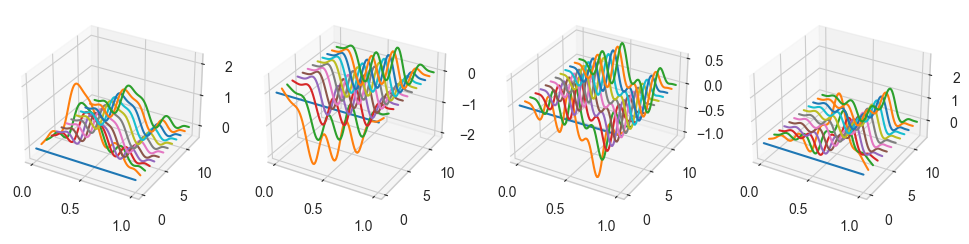

In [182]:
plt_idxs = [0,1,2,3]
ncols = len(plt_idxs)
fig = pyplot.figure(figsize=(12,4))
ax = np.empty(ncols,dtype=object)
_gs = gridspec.GridSpec(1,ncols) 
for i in range(ncols): ax[i] = fig.add_subplot(_gs[0,i],projection="3d")
for i in range(ncols):
    for k in range(vopt.size(1)):
        ax[i].plot(xticks,k,vopt[plt_idxs[i],k,:nxticks])

## ML modeling

### Train Test Split

In [183]:
uticks.shape,vopt.shape
val_frac = 1/8
tv_idx = torch.arange(R)#torch.from_numpy(dnb2.rng.permutation(R))
n_train = R-int(val_frac*R)
n_val = R-n_train
tidx = tv_idx[:n_train]
vidx = tv_idx[n_train:]
print("number train u: %d"%n_train)
print("number val   u: %d"%n_val)
uticks_train = uticks[tidx]
uticks_val = uticks[vidx]
vopt_train = vopt[tidx]
vopt_val = vopt[vidx]
vticks_train = vticks[tidx]
vticks_val = vticks[vidx]

number train u: 896
number val   u: 128


### Gaussian Process

In [186]:
_rr_train,_ii_train = torch.cartesian_prod(
    torch.arange(n_train),
    torch.arange(3)).T
uv_train = torch.hstack([uticks_train[_rr_train,:],vopt_train[_rr_train,_ii_train,:nxticks]])
_rr_val,_ii_val = torch.cartesian_prod(
    torch.arange(n_val),
    torch.arange(maxiter)).T
uv_val = torch.hstack([uticks_val[_rr_val,:],vopt_val[_rr_val,_ii_val,:nxticks]])
print(uticks_train.shape,vopt_train.shape,uv_train.shape)
print(uticks_val.shape,vopt_val.shape,uv_val.shape)

torch.Size([896, 101]) torch.Size([896, 13, 204]) torch.Size([2688, 202])
torch.Size([128, 101]) torch.Size([128, 13, 204]) torch.Size([1536, 202])


In [185]:
# https://docs.gpytorch.ai/en/v1.12/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html
class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        #self.mean_module = gpytorch.means.LinearMean(input_size=2*nxticks,batch_shape=torch.Size([nxticks]))
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([nxticks]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                ard_num_dims = None, 
                #ard_num_dims = 2*nxticks, 
                batch_shape=torch.Size([nxticks])),
            batch_shape=torch.Size([nxticks])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

_y_train = vopt_train[_rr_train,_ii_train+1,:nxticks]

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=nxticks)
model = BatchIndependentMultitaskGPModel(uv_train, _y_train, likelihood)

model = model.double()

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()
# Use the Adam optimizer
training_iterations = 100
optimizer = torch.optim.Adam(model.parameters(), lr=.1)  # Includes GaussianLikelihood parameters

verbosity = max(1,int(training_iterations/20))
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(uv_train)
    loss = -mll(output, _y_train)
    loss.backward()
    if (i+1)%verbosity==0: print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 5/100 - Loss: 1.363
Iter 10/100 - Loss: 1.252
Iter 15/100 - Loss: 1.152
Iter 20/100 - Loss: 1.063


KeyboardInterrupt: 

In [ ]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(uv_val)).mean
vticks_hat_val_gp = predictions.reshape((-1,maxiter,nxticks))
vticks_hat_val_gp.shape

In [ ]:
vopt_val_comp = vopt_val[:,1:,:nxticks]
l2rerrors_gp = torch.linalg.norm(vticks_hat_val_gp-vopt_val_comp,dim=2)/torch.linalg.norm(vopt_val_comp,dim=2)
fig,ax = pyplot.subplots(nrows=1,ncols=1,figsize=(7,4))
for i in range(maxiter):
    ax.scatter((i+1)*torch.ones(n_val),l2rerrors_gp[:,i])
ax.set_yscale("log",base=10)

/var/folders/rz/_ktvltjs49v_z33w0h6njx5w0000gn/T/ipykernel_65515/189334273.py:35


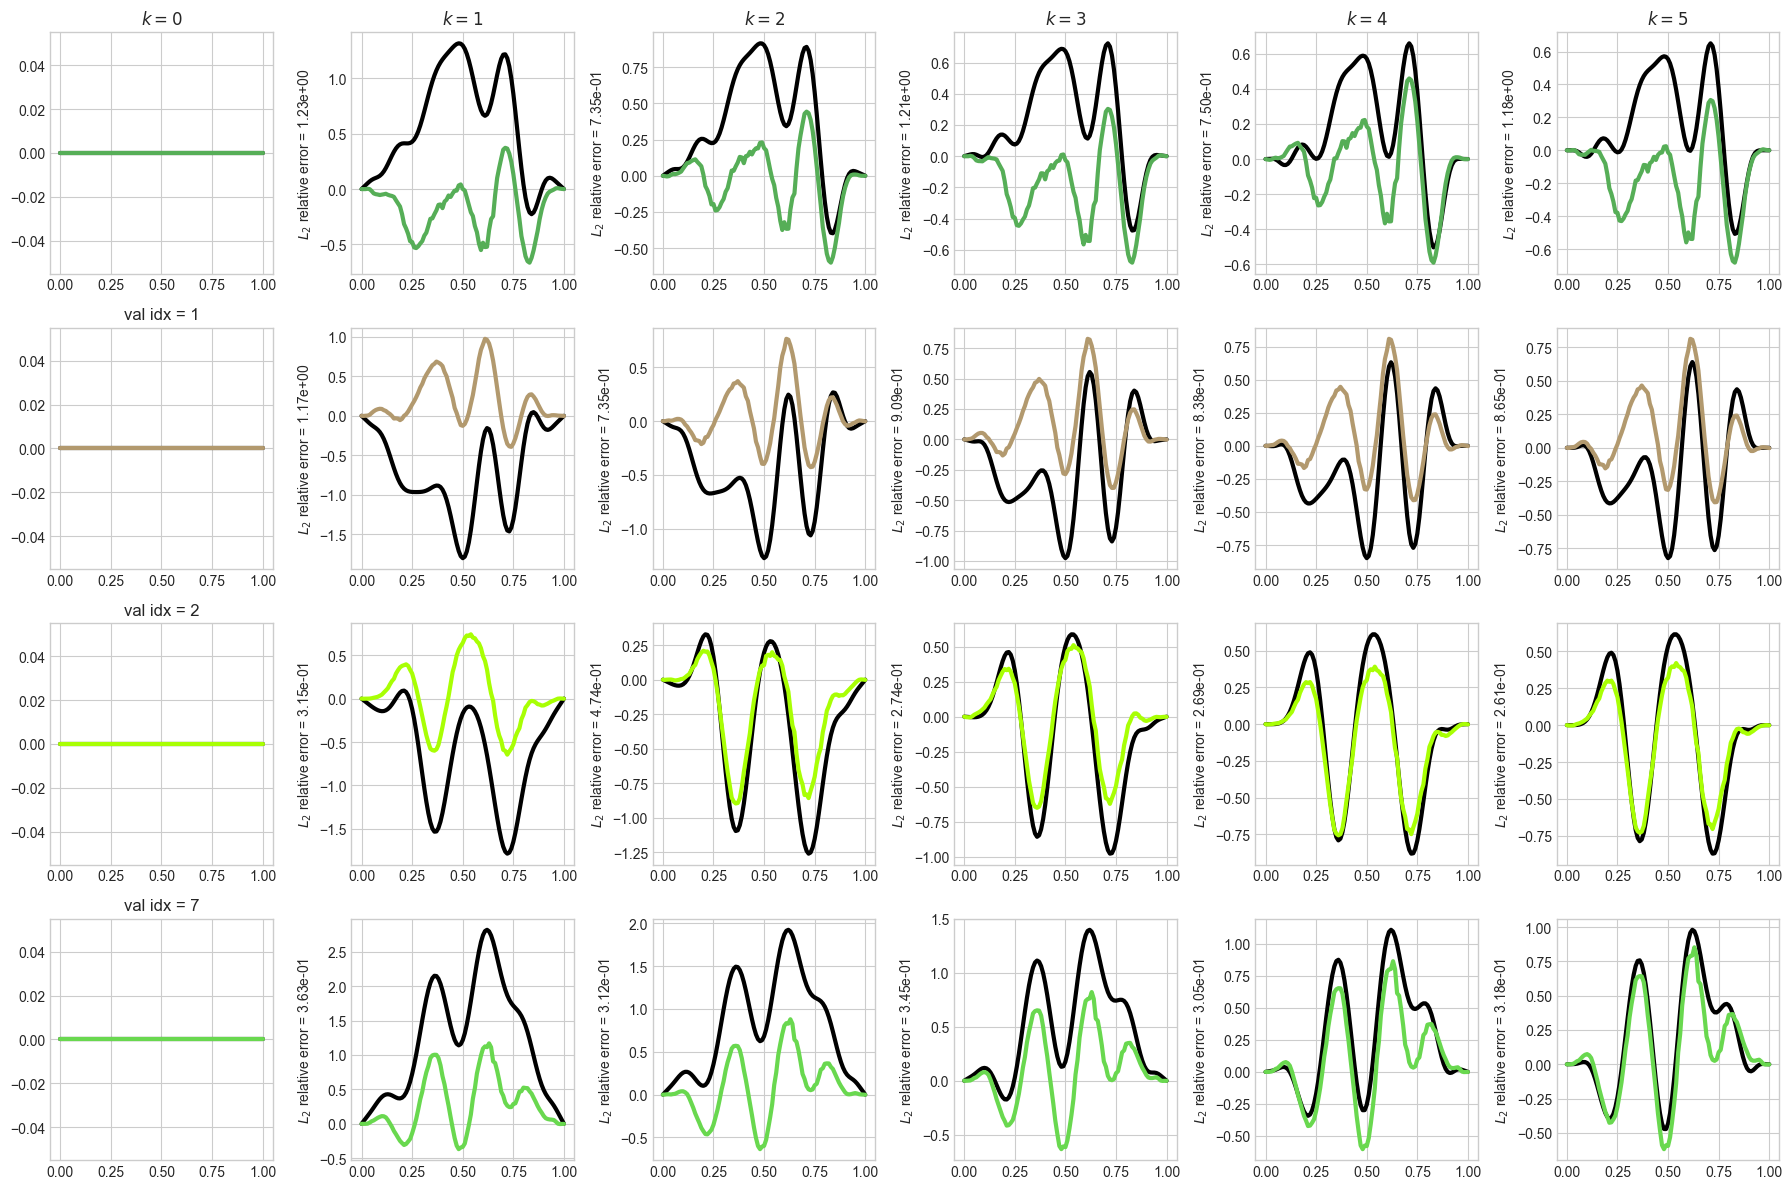

In [70]:
pidxs = [0,1,2,7]
nrows = len(pidxs)
ncols = 6#maxiter+1
vhat = torch.zeros((nrows,ncols,nxticks))
for k in range(ncols-1):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        vhat[:,k+1,:] = likelihood(model(torch.hstack([uticks_val[pidxs],vhat[:,k,:]]))).mean
l2rerrors = torch.linalg.norm(vhat-vticks_val[pidxs,None,:],dim=2)/torch.linalg.norm(vticks_val[pidxs,None,:],dim=2)
l2rerrors_iter = torch.linalg.norm(vhat-vopt_val[pidxs,:ncols,:nxticks],dim=2)/torch.linalg.norm(vopt_val[pidxs,:ncols,:nxticks],dim=2)
aerrors = torch.abs(vhat[:,-1,:]-vticks_val[pidxs,:])
# fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=((12,5)))
# for i in range(nrows):
#     ax[0].plot(torch.arange(ncols),l2rerrors_iter[i],linewidth=LW,color=COLORS[i])
#     ax[1].plot(torch.arange(ncols),l2rerrors[i],linewidth=LW,color=COLORS[i])
#     ax[2].plot(xticks,aerrors[i],linewidth=LW,color=COLORS[i])
# for i in range(3):
#     ax[i].set_yscale("log",base=10)
# fig.show()
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(3*ncols,3*nrows))
for i in range(nrows):
    #ymin,ymax = vhat[i,:,:nxticks].min(),vhat[i,:,:nxticks].max()
    ymin,ymax = vhat.min(),vhat.max()
    yymin,yymax = ymin-(ymax-ymin)*.1,ymax+(ymax-ymin)*.1
    for k in range(ncols):
        ax[i,k].plot(xticks,vopt_val[pidxs[i],k,:nxticks],linewidth=LW,color="k")
        ax[i,k].plot(xticks,vhat[i,k,:nxticks],linewidth=LW,color=COLORS[i])
        #ax[i,k].set_ylim([yymin,yymax])
        if k>0:
            ax[i,k].set_ylabel(r"$L_2$ relative error = %.2e"%l2rerrors[i,k])
for i in range(nrows):
    ax[i,0].set_title("val idx = %d"%pidxs[i])
for k in range(ncols):
    ax[0,k].set_title(r"$k = %d$"%k)
fig.tight_layout()
fig.show()
# fig = pyplot.figure(figsize=(11,6))
# _gs = gridspec.GridSpec(2,ncols-1) 
# CUSTOMCOLORS = ["xkcd:grass green","xkcd:sky blue","xkcd:rose","xkcd:brown"]+COLORS
# ax = fig.add_subplot(_gs[0,:])
# for i in range(nrows):
#     ax.plot(torch.arange(1,ncols),l2rerrors[i,1:],marker="o",linewidth=LW,color=CUSTOMCOLORS[i])
# ax.set_yscale("log",base=10)
# ax.set_xlim([.6,ncols-.6])
# ax.set_xlabel(r"iteration $k$",fontsize="xx-large")
# ax.set_ylabel(r"$L_2$ relative error",fontsize="xx-large")
# ax = np.empty(ncols-1,dtype=object)
# for k in range(ncols-1):
#     ax[k] = fig.add_subplot(_gs[1,k])
#     ax[k].set_xlim([0,1])
#     ax[k].set_xticks([0,1/4,1/2,3/4,1])
#     ax[k].set_xticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
#     ax[k].set_ylim([ymin-.05*(ymax-ymin),ymax+.05*(ymax-ymin)])
#     ax[k].set_xlabel(r"$x$",fontsize="xx-large")
# ymin,ymax = vhat[:,1:ncols,:nxticks].min(),vhat[:,1:ncols,:nxticks].max()
# for k in range(ncols-1):
#     for i in range(nrows):
#         ax[k].plot(xticks,vhat[i,k+1,:nxticks],linewidth=LW,color=CUSTOMCOLORS[i])
    
# for k in range(1,ncols-1):
#     ax[k].set_yticklabels([""]*len(ax[k].get_yticklabels()))#get_yaxis().set_visible(False)
# ax[0].set_ylabel(r"$v(x)$",fontsize="xx-large")
# fig.tight_layout()
# fig.show()
# fig.savefig("./superres_gp.png",dpi=512,bbox_inches="tight")

### MLP

In [187]:
class MultilayerPerceptron(torch.nn.Module):
    def __init__(self, mlp_layer_nodes:list, activation_function:torch.nn.Module=torch.nn.Tanh(), activate_last_layer:bool=False, scale_last_layer:bool=True, bias_last_layer:bool=True, weight_init_scheme:callable=None):
        super().__init__()
        num_layers = len(mlp_layer_nodes)-1
        self.mlp_layer_nodes = mlp_layer_nodes
        self.output_nodes = self.mlp_layer_nodes[-1]
        layers = []
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore",".*Initializing zero-element tensors is a no-op*") # occurs when setting a layer with 0 inputs
            for i in range(num_layers):
                layer = torch.nn.Linear(self.mlp_layer_nodes[i],self.mlp_layer_nodes[i+1])
                if callable(weight_init_scheme):
                    weight_init_scheme(layer.weight)
                layer.bias.data.fill_(0. if self.mlp_layer_nodes[i]>0 else 1.)
                layers.extend([layer,activation_function])
        self.mlp_sequential = torch.nn.Sequential(*(layers if activate_last_layer else layers[:-1]))
        self.logscale,self.bias = torch.tensor(0.),torch.tensor(0.)
        if scale_last_layer: self.logscale = torch.nn.parameter.Parameter(self.logscale)
        if bias_last_layer: self.bias = torch.nn.parameter.Parameter(self.bias)
    def output_transform(self, x:torch.Tensor):
        return x
    def forward(self, x):
        x = self.mlp_sequential(x).squeeze()
        x = self.output_transform(x)
        return torch.exp(self.logscale)*x+self.bias

#### Interior only

In [211]:
class DatasetMLPi(torch.utils.data.Dataset):
    def __init__(self, u, v, device="cpu", steps="all", fp32=False):
        self.u = u
        self.v = v[:,:,:nxticks]
        if fp32:
            self.u = self.u.to(torch.float32)
            self.v = self.v.to(torch.float32)
        steps = self.v.size(1) if steps=="all" else steps
        self.i_r,self.i_k = torch.cartesian_prod(torch.arange(self.u.size(0)),torch.arange(steps-1)).T
        self._put_on_device(device)
    def __getitems__(self, i):
        i = torch.tensor(i,dtype=torch.int)
        ir,ik = self.i_r[i],self.i_k[i]
        return self.u[ir],self.v[ir,ik,:],self.v[ir,ik+1,:]
    def __len__(self):
        return len(self.i_r)
    def _put_on_device(self, device):
        self.i_r,self.i_k = self.i_r.to(device),self.i_k.to(device)
        self.u,self.v = self.u.to(device),self.v.to(device)
class MLPLightningi(lightning.LightningModule):
    def __init__(self, mlp, automatic_optimization=True):
        super().__init__()
        self.mlp = mlp
        self.automatic_optimization = automatic_optimization
    def _common_step(self, batch, tag):
        u,v,vnext = batch
        inputs = torch.hstack([u,v])
        vnext_hat = self.mlp(inputs)
        loss = torch.nn.functional.l1_loss(vnext_hat,vnext)
        #loss = torch.sqrt(torch.nn.functional.mse_loss(vnext_hat,vnext))
        #loss = torch.mean(torch.abs(vnext_hat-vnext).sum(1)**(1/2))
        #loss = torch.mean(torch.linalg.norm(vnext_hat-vnext,dim=1)/(torch.linalg.norm(vnext-v,dim=1)**1/8))
        self.log(tag+"_loss",loss,prog_bar=tag!="val",logger=True,sync_dist=True,on_step=False,on_epoch=True)
        if tag=="val":
            vnext_hat_r = vnext_hat.reshape((n_val,maxiter,nxticks))
            vnext_r = vnext.reshape((n_val,maxiter,nxticks))
            l2rerrors = torch.linalg.norm(vnext_hat_r-vnext_r,dim=2)/torch.linalg.norm(vnext_r,dim=2)
            mean_k_l2rerrors = l2rerrors.mean(0)
            mean_l2rerror = mean_k_l2rerrors.mean(0)
            self.log(tag+"_mean_l2rerror",mean_l2rerror,prog_bar=tag!="val",logger=True,sync_dist=True,on_step=False,on_epoch=True)
            for k in range(len(mean_k_l2rerrors)):
                self.log(tag+"_mean_l2rerror_%d"%k,mean_k_l2rerrors[k],prog_bar=tag!="val",logger=True,sync_dist=True,on_step=False,on_epoch=True)
        return loss
    def training_step(self, batch, batch_idx):
        if self.automatic_optimization:
            return self._common_step(batch,tag="train")
        else:
            opt = self.optimizers()
            def closure():
                loss = self._common_step(batch,tag="train")
                opt.zero_grad(set_to_none=True)
                self.manual_backward(loss)
                return loss
            opt.step(closure=closure)
    def validation_step(self, batch, batch_idx):
        with torch.inference_mode(True):
          return self._common_step(batch,tag="val")
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),lr=1e-3,amsgrad=True)
        # if self.trainer.current_epoch>=2000:
        #     optimizer = torch.optim.LBFGS(self.parameters())#,lr=1e-2,amsgrad=True)
        return optimizer

In [212]:
import gc
gc.collect()
torch.cuda.empty_cache()
save_dir = "MLP_i"
name = "MLP_i_superres_fp64"
resume = False
mlp = MultilayerPerceptron(
    mlp_layer_nodes = [2*nxticks,2*nxticks,2*nxticks,2*nxticks,nxticks],
    #activation_function = torch.nn.ReLU(),
    #activation_function = torch.nn.Tanh(),
    activation_function = torch.nn.SiLU(),
    #weight_init_scheme = torch.nn.init.kaiming_normal_
)
mlp_lightning = MLPLightningi(mlp)
mlp.to("cpu")
mlp.to(torch.float64)
dataset_mlp_train = DatasetMLPi(uticks_train,vopt_train,device="cpu",steps=maxiter)
dataset_mlp_val = DatasetMLPi(uticks_val,vopt_val,device="cpu")
print("number train: %.2e"%len(dataset_mlp_train))
print("number val  : %.2e"%len(dataset_mlp_val))
def batched_collate_fn(batch):
    return tuple(batch)
dataloader_mlp_train = torch.utils.data.DataLoader(dataset_mlp_train,batch_size=2**8,collate_fn=batched_collate_fn,shuffle=True)
dataloader_mlp_val = torch.utils.data.DataLoader(dataset_mlp_val,batch_size=len(dataset_mlp_val),collate_fn=batched_collate_fn,shuffle=False)
csv_logger = lightning.pytorch.loggers.CSVLogger(save_dir=save_dir,name=name,version='csv')
trainer = lightning.Trainer(
    max_epochs = 256,
    logger = [csv_logger],
    #limit_train_batches=2**10,
    #log_every_n_steps = 1e10,
    enable_progress_bar = True,
    #num_sanity_val_steps = 0,
    gradient_clip_val = 0.0,
    gradient_clip_algorithm = "norm",
  )
trainer.fit(model=mlp_lightning, train_dataloaders=dataloader_mlp_train, val_dataloaders=dataloader_mlp_val,
    ckpt_path = sorted(glob.glob("./%s/%s/csv/checkpoints/*.ckpt"%(save_dir,name)),key=os.path.getmtime)[-1] if resume else None,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory MLP_i/MLP_i_superres_fp64/csv exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory MLP_i/MLP_i_superres_fp64/csv/checkpoints exists and is not empty.

  | Name | Type                 | Params | Mode 
------------------------------------------------------
0 | mlp  | MultilayerPerceptron | 143 K  | train
------------------------------------------------------
143 K     Trainable params
0         Non-trainable params
143 K     Total params
0.574     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


number train: 9.86e+03
number val  : 1.54e+03


Sanity Checking: |                                                       | 0/? [00:00<?, ?it/s]

/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                              | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=256` reached.


train_loss  val_loss  val_mean_l2rerror  val_mean_l2rerror_0  \
1      0.209842  0.119925           0.300978             0.819280   
26     0.022957  0.022963           0.062535             0.188549   
51     0.014042  0.015082           0.042669             0.101643   
76     0.011850  0.013288           0.039032             0.074777   
101    0.010517  0.011626           0.034622             0.060118   
126    0.009335  0.011038           0.034247             0.049809   
151    0.008026  0.010368           0.030431             0.059057   
176    0.008681  0.009499           0.029070             0.042477   
201    0.007376  0.010915           0.032993             0.064955   
226    0.007196  0.010103           0.030449             0.053296   
251    0.007256  0.009110           0.027206             0.041418   

     val_mean_l2rerror_1  val_mean_l2rerror_2  val_mean_l2rerror_3  \
1               0.230827             0.257775             0.261567   
26              0.061003             0.058270             0.053822   
51              0.042546             0.039317             0.037633   
76              0.035559             0.038182             0.036906   
101             0.035155             0.036161             0.035041   
126             0.033411             0.035531             0.034307   
151             0.031653             0.030356             0.029242   
176             0.028968             0.029685             0.028815   
201             0.027965             0.029444             0.030435   
226             0.027854             0.028120             0.028949   
251             0.028116             0.026811             0.025913   

     val_mean_l2rerror_4  val_mean_l2rerror_5  val_mean_l2rerror_6  \
1               0.261439             0.257194             0.255539   
26              0.052947             0.047969             0.047145   
51              0.035755             0.035332             0.035241   
76              0.035426             0.033955             0.033661   
101             0.032581             0.029831             0.029832   
126             0.032395             0.031122             0.031196   
151             0.026777             0.025518             0.025639   
176             0.027570             0.026034             0.025875   
201             0.029188             0.029341             0.029839   
226             0.027536             0.026746             0.027109   
251             0.024730             0.023933             0.023989   

     val_mean_l2rerror_7  val_mean_l2rerror_8  val_mean_l2rerror_9  \
1               0.253806             0.253591             0.253571   
26              0.047154             0.048274             0.048428   
51              0.035404             0.037123             0.037343   
76              0.034284             0.036225             0.036469   
101             0.029941             0.031536             0.031754   
126             0.031309             0.032813             0.033021   
151             0.025844             0.027593             0.027830   
176             0.026254             0.028109             0.028351   
201             0.029773             0.031093             0.031291   
226             0.027572             0.029373             0.029610   
251             0.024567             0.026561             0.026811   

     val_mean_l2rerror_10  val_mean_l2rerror_11  
1                0.253571              0.253571  
26               0.048429              0.048429  
51               0.037345              0.037345  
76               0.036472              0.036472  
101              0.031757              0.031757  
126              0.033024              0.033024  
151              0.027833              0.027833  
176              0.028354              0.028354  
201              0.031293              0.031293  
226              0.029612              0.029612  
251              0.026814              0.026814

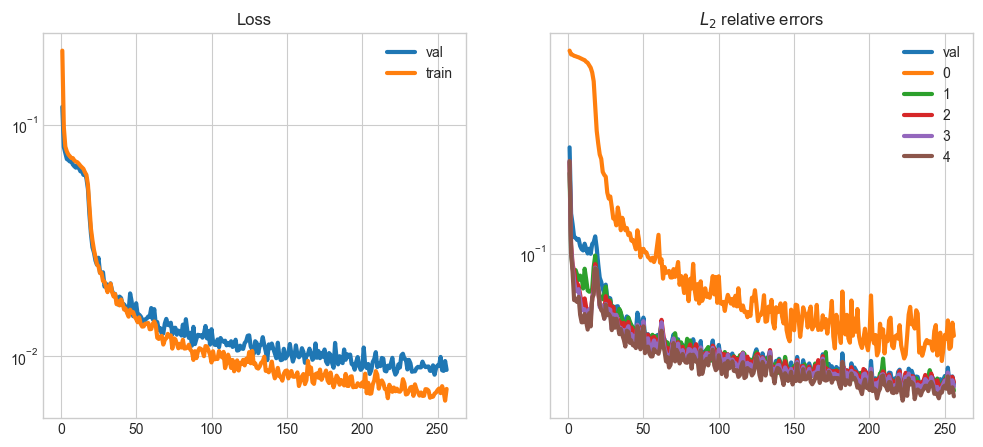

In [213]:
metrics = pd.read_csv("%s/%s/csv/metrics.csv"%(save_dir,name))
metrics
metrics_train = metrics.iloc[~np.isnan(metrics["train_loss"].values)]
metrics_val = metrics.iloc[~np.isnan(metrics["val_loss"].values)]
metrics
parsed_metrics = {
    "train_loss": metrics_train["train_loss"].values,
    "val_loss": metrics_val["val_loss"].values,
    "val_mean_l2rerror": metrics_val["val_mean_l2rerror"].values,
}
for k in range(maxiter):
    parsed_metrics["val_mean_l2rerror_%d"%k] = metrics_val["val_mean_l2rerror_%d"%k].values
metrics = pd.DataFrame(parsed_metrics)
metrics.index = metrics.index+1
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(12,5))
ax[0].set_title(r"Loss")
ax[0].plot(metrics.index,metrics["val_loss"],label="val",linewidth=LW)
ax[0].plot(metrics.index,metrics["train_loss"],label="train",linewidth=LW)
ax[0].legend()
ax[0].set_yscale("log",base=10)
ax[1].set_title(r"$L_2$ relative errors")
ax[1].plot(metrics.index,metrics["val_mean_l2rerror"],label="val",linewidth=LW)
for k in range(5):#maxiter):
    ax[1].plot(metrics.index,metrics["val_mean_l2rerror_%d"%k],label=k,linewidth=LW)#,color="k",alpha=(maxiter-k)/maxiter)
ax[1].legend()
ax[1].set_yscale("log",base=10)
metrics.iloc[::max(1,len(metrics)//10)]

/var/folders/rz/_ktvltjs49v_z33w0h6njx5w0000gn/T/ipykernel_65515/355485104.py:18
/var/folders/rz/_ktvltjs49v_z33w0h6njx5w0000gn/T/ipykernel_65515/355485104.py:35
/var/folders/rz/_ktvltjs49v_z33w0h6njx5w0000gn/T/ipykernel_65515/355485104.py:59
/var/folders/rz/_ktvltjs49v_z33w0h6njx5w0000gn/T/ipykernel_65515/355485104.py:59
/var/folders/rz/_ktvltjs49v_z33w0h6njx5w0000gn/T/ipykernel_65515/355485104.py:59
/var/folders/rz/_ktvltjs49v_z33w0h6njx5w0000gn/T/ipykernel_65515/355485104.py:59
/var/folders/rz/_ktvltjs49v_z33w0h6njx5w0000gn/T/ipykernel_65515/355485104.py:59
/var/folders/rz/_ktvltjs49v_z33w0h6njx5w0000gn/T/ipykernel_65515/355485104.py:59
/var/folders/rz/_ktvltjs49v_z33w0h6njx5w0000gn/T/ipykernel_65515/355485104.py:59
/var/folders/rz/_ktvltjs49v_z33w0h6njx5w0000gn/T/ipykernel_65515/355485104.py:59
/var/folders/rz/_ktvltjs49v_z33w0h6njx5w0000gn/T/ipykernel_65515/355485104.py:59
/var/folders/rz/_ktvltjs49v_z33w0h6njx5w0000gn/T/ipykernel_65515/355485104.py:59
/var/folders/rz/_ktvltjs49v_

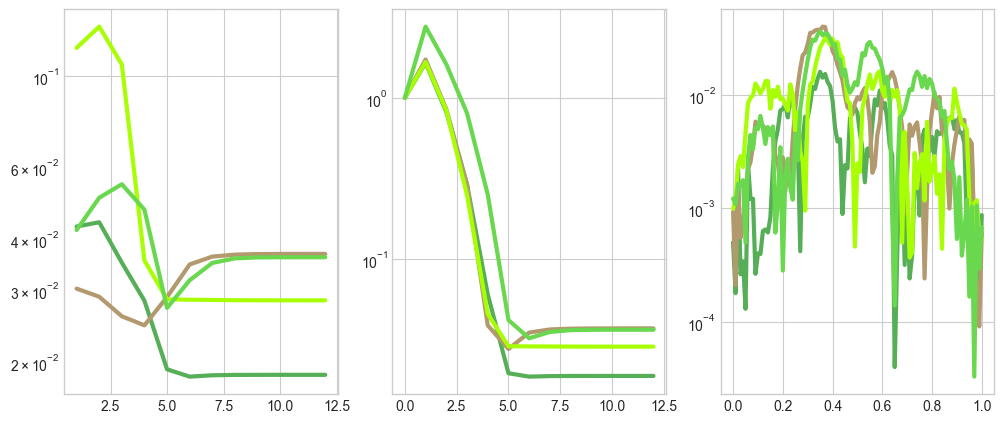

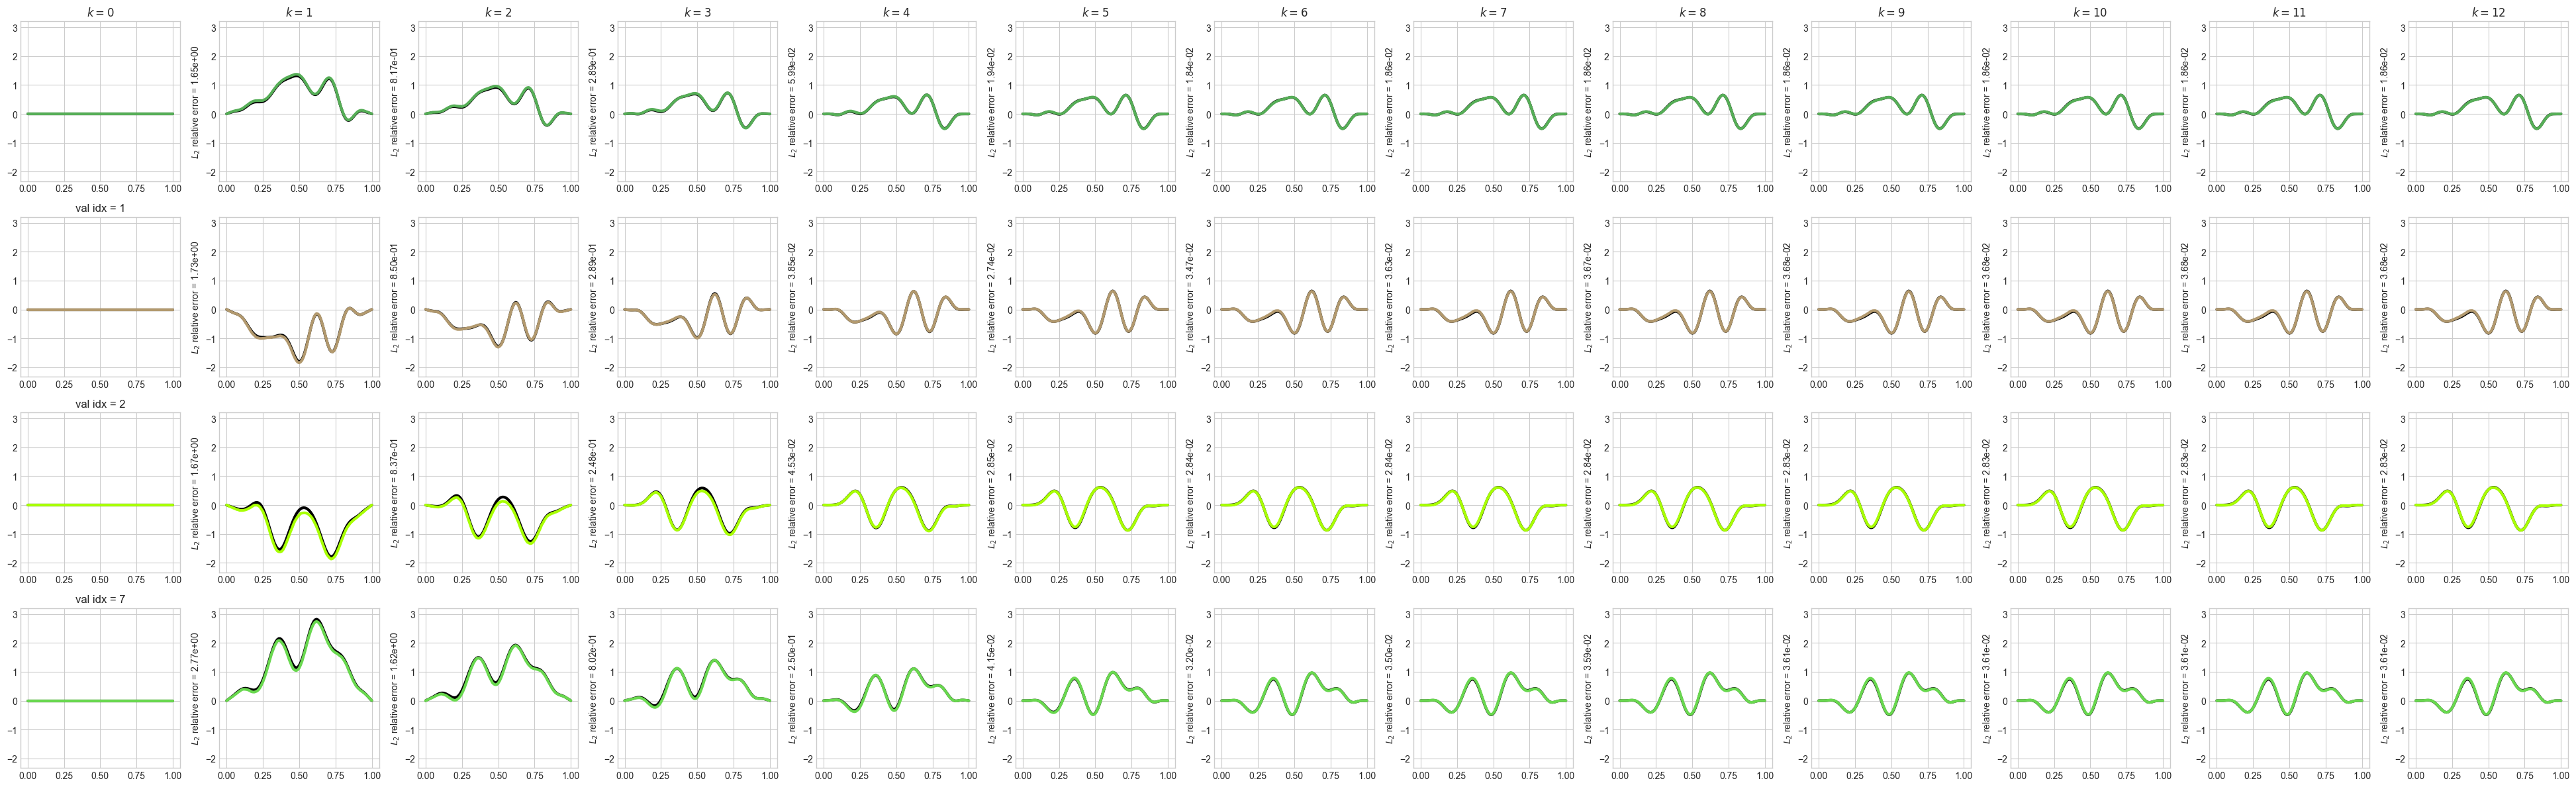

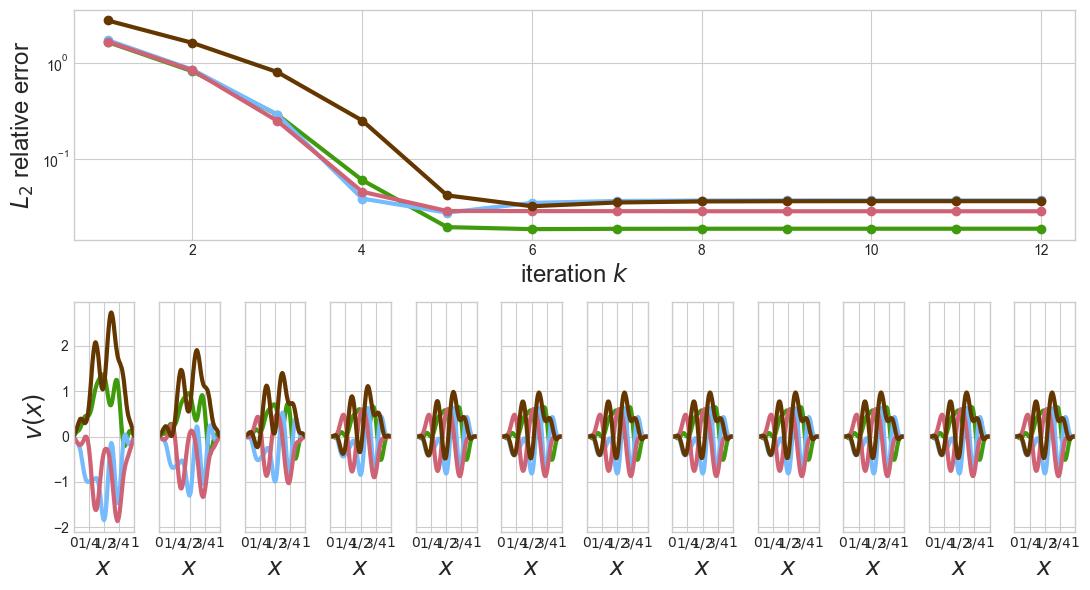

In [214]:
pidxs = [0,1,2,7]
nrows = len(pidxs)
ncols = maxiter+1
vhat = torch.zeros((nrows,ncols,nxticks))
for k in range(ncols-1):
    with torch.inference_mode(True):
        vhat[:,k+1,:] = mlp(torch.hstack([uticks_val[pidxs],vhat[:,k,:]]))
l2rerrors = torch.linalg.norm(vhat-vticks_val[pidxs,None,:],dim=2)/torch.linalg.norm(vticks_val[pidxs,None,:],dim=2)
l2rerrors_iter = torch.linalg.norm(vhat-vopt_val[pidxs,:ncols,:nxticks],dim=2)/torch.linalg.norm(vopt_val[pidxs,:ncols,:nxticks],dim=2)
aerrors = torch.abs(vhat[:,-1,:]-vticks_val[pidxs,:])
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=((12,5)))
for i in range(nrows):
    ax[0].plot(torch.arange(ncols),l2rerrors_iter[i],linewidth=LW,color=COLORS[i])
    ax[1].plot(torch.arange(ncols),l2rerrors[i],linewidth=LW,color=COLORS[i])
    ax[2].plot(xticks,aerrors[i],linewidth=LW,color=COLORS[i])
for i in range(3):
    ax[i].set_yscale("log",base=10)
fig.show()
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(3*ncols,3*nrows))
for i in range(nrows):
    #ymin,ymax = vhat[i,:,:nxticks].min(),vhat[i,:,:nxticks].max()
    ymin,ymax = vhat.min(),vhat.max()
    yymin,yymax = ymin-(ymax-ymin)*.1,ymax+(ymax-ymin)*.1
    for k in range(ncols):
        ax[i,k].plot(xticks,vopt_val[pidxs[i],k,:nxticks],linewidth=LW,color="k")
        ax[i,k].plot(xticks,vhat[i,k,:nxticks],linewidth=LW,color=COLORS[i])
        ax[i,k].set_ylim([yymin,yymax])
        if k>0:
            ax[i,k].set_ylabel(r"$L_2$ relative error = %.2e"%l2rerrors[i,k])
for i in range(nrows):
    ax[i,0].set_title("val idx = %d"%pidxs[i])
for k in range(ncols):
    ax[0,k].set_title(r"$k = %d$"%k)
fig.tight_layout()
fig.show()
fig = pyplot.figure(figsize=(11,6))
_gs = gridspec.GridSpec(2,ncols-1) 
CUSTOMCOLORS = ["xkcd:grass green","xkcd:sky blue","xkcd:rose","xkcd:brown"]+COLORS
ax = fig.add_subplot(_gs[0,:])
for i in range(nrows):
    ax.plot(torch.arange(1,ncols),l2rerrors[i,1:],marker="o",linewidth=LW,color=CUSTOMCOLORS[i])
ax.set_yscale("log",base=10)
ax.set_xlim([.6,ncols-.6])
ax.set_xlabel(r"iteration $k$",fontsize="xx-large")
ax.set_ylabel(r"$L_2$ relative error",fontsize="xx-large")
ax = np.empty(ncols-1,dtype=object)
for k in range(ncols-1):
    ax[k] = fig.add_subplot(_gs[1,k])
    ax[k].set_xlim([0,1])
    ax[k].set_xticks([0,1/4,1/2,3/4,1])
    ax[k].set_xticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
    ax[k].set_ylim([ymin-.05*(ymax-ymin),ymax+.05*(ymax-ymin)])
    ax[k].set_xlabel(r"$x$",fontsize="xx-large")
ymin,ymax = vhat[:,1:ncols,:nxticks].min(),vhat[:,1:ncols,:nxticks].max()
for k in range(ncols-1):
    for i in range(nrows):
        ax[k].plot(xticks,vhat[i,k+1,:nxticks],linewidth=LW,color=CUSTOMCOLORS[i])
for k in range(1,ncols-1):
    ax[k].set_yticklabels([""]*len(ax[k].get_yticklabels()))#get_yaxis().set_visible(False)
ax[0].set_ylabel(r"$v(x)$",fontsize="xx-large")
fig.tight_layout()
fig.show()
fig.savefig("./superres.png",dpi=512,bbox_inches="tight")

#### Full

In [233]:
class DatasetMLP(torch.utils.data.Dataset):
    def __init__(self, u, v, device="cpu"):
        self.u = u.to(torch.float64)
        self.v = v.to(torch.float64)
        self.i_r,self.i_k = torch.cartesian_prod(torch.arange(self.u.size(0)),torch.arange(self.v.size(1)-1)).T
        self._put_on_device(device)
    def __getitems__(self, i):
        i = torch.tensor(i,dtype=torch.int)
        ir,ik = self.i_r[i],self.i_k[i]
        return self.u[ir],self.v[ir,ik,:],self.v[ir,ik+1,:]
    def __len__(self):
        return len(self.i_r)
    def _put_on_device(self, device):
        self.i_r,self.i_k = self.i_r.to(device),self.i_k.to(device)
        self.u,self.v = self.u.to(device),self.v.to(device)
class MLPLightning(lightning.LightningModule):
    def __init__(self, mlp, automatic_optimization=True):
        super().__init__()
        self.mlp = mlp
        self.automatic_optimization = automatic_optimization
    def _common_step(self, batch, tag):
        u,v,vnext = batch
        inputs = torch.hstack([u,v])
        vnext_hat = self.mlp(inputs)
        #loss = torch.sqrt(torch.nn.functional.mse_loss(vnext_hat,vnext))
        loss = torch.nn.functional.l1_loss(vnext_hat,vnext)
        self.log(tag+"_loss",loss,prog_bar=tag!="val",logger=True,sync_dist=True,on_step=False,on_epoch=True)
        if tag=="val":
            vnext_hat_r = vnext_hat.reshape((n_val,maxiter,ki.length))[:,:,:nxticks]
            vnext_r = vnext.reshape((n_val,maxiter,ki.length))[:,:,:nxticks]
            l2rerrors = torch.linalg.norm(vnext_hat_r-vnext_r,dim=2)/torch.linalg.norm(vnext_r,dim=2)
            mean_k_l2rerrors = l2rerrors.mean(0)
            mean_l2rerror = mean_k_l2rerrors.mean(0)
            self.log(tag+"_mean_l2rerror",mean_l2rerror,prog_bar=tag!="val",logger=True,sync_dist=True,on_step=False,on_epoch=True)
            for k in range(len(mean_k_l2rerrors)):
                self.log(tag+"_mean_l2rerror_%d"%k,mean_k_l2rerrors[k],prog_bar=tag!="val",logger=True,sync_dist=True,on_step=False,on_epoch=True)
        return loss
    def training_step(self, batch, batch_idx):
        if self.automatic_optimization:
            return self._common_step(batch,tag="train")
        else:
            opt = self.optimizers()
            def closure():
                loss = self._common_step(batch,tag="train")
                opt.zero_grad(set_to_none=True)
                self.manual_backward(loss)
                return loss
            opt.step(closure=closure)
    def validation_step(self, batch, batch_idx):
        with torch.inference_mode(True):
          return self._common_step(batch,tag="val")
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),lr=1e-3,amsgrad=True)
        # if self.trainer.current_epoch>=20:
        #     optimizer = torch.optim.LBFGS(self.parameters())#,lr=1e-2,amsgrad=True)
        return optimizer

In [240]:
import gc
gc.collect()
torch.cuda.empty_cache()
save_dir = "MLP"
name = "MLP_save"
resume = False
mlp = MultilayerPerceptron(
    mlp_layer_nodes = [nxticks+ki.length,nxticks+ki.length,nxticks+ki.length,ki.length],
    #activation_function = torch.nn.ReLU(),
    activation_function = torch.nn.Tanh(),
    #activation_function = torch.nn.SiLU(),
    weight_init_scheme = torch.nn.init.xavier_uniform_
    # weight_init_scheme = torch.nn.init.kaiming_uniform_
)
mlp_lightning = MLPLightning(mlp)
mlp.to("cpu")
mlp.to(torch.float64)
dataset_mlp_train = DatasetMLP(uticks_train,vopt_train,device="cpu")
dataset_mlp_val = DatasetMLP(uticks_val,vopt_val,device="cpu")
print("number train: %.2e"%len(dataset_mlp_train))
print("number val  : %.2e"%len(dataset_mlp_val))
def batched_collate_fn(batch):
    return tuple(batch)
dataloader_mlp_train = torch.utils.data.DataLoader(dataset_mlp_train,batch_size=2**8,collate_fn=batched_collate_fn,shuffle=True)
dataloader_mlp_val = torch.utils.data.DataLoader(dataset_mlp_val,batch_size=len(dataset_mlp_val),collate_fn=batched_collate_fn,shuffle=False)
csv_logger = lightning.pytorch.loggers.CSVLogger(save_dir=save_dir,name=name,version='csv')
trainer = lightning.Trainer(
    max_epochs = 50,
    logger = [csv_logger],
    #limit_train_batches=2**10,
    #log_every_n_steps = 1e10,
    enable_progress_bar = True,
    #num_sanity_val_steps = 0,
    #gradient_clip_val = 0.0,
    #gradient_clip_algorithm = "norm",
  )
trainer.fit(model=mlp_lightning, train_dataloaders=dataloader_mlp_train, val_dataloaders=dataloader_mlp_val,
    ckpt_path = sorted(glob.glob("./%s/%s/csv/checkpoints/*.ckpt"%(save_dir,name)),key=os.path.getmtime)[-1] if resume else None,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory MLP/MLP_save/csv exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory MLP/MLP_save/csv/checkpoints exists and is not empty.

  | Name | Type                 | Params | Mode 
------------------------------------------------------
0 | mlp  | MultilayerPerceptron | 249 K  | train
------------------------------------------------------
249 K     Trainable params
0         Non-trainable params
249 K     Total params
0.996     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


number train: 1.08e+04
number val  : 1.54e+03


Sanity Checking: |                                                       | 0/? [00:00<?, ?it/s]

/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (42) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                              | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


train_loss   val_loss  val_mean_l2rerror  val_mean_l2rerror_0  \
1    61.891148  61.049246           0.974828             0.978401   
6    49.306298  48.166271           0.996415             1.004311   
11   33.973855  32.849918           1.184454             1.063225   
16   18.492990  19.124246           1.144114             1.056716   
21   11.926179  14.577589           0.842250             0.909410   
26    9.790482  13.540145           0.745759             0.872513   
31    8.568323  13.034035           0.717393             0.856051   
36    7.718290  13.081373           0.745194             0.849462   
41    7.058565  12.910772           0.713794             0.835915   
46    6.337758  12.627764           0.701243             0.838093   

    val_mean_l2rerror_1  val_mean_l2rerror_2  val_mean_l2rerror_3  \
1              0.984900             0.982255             0.979153   
6              1.003940             1.007757             1.004618   
11             1.125694             1.168331             1.197220   
16             1.101414             1.144081             1.165647   
21             0.904680             0.872102             0.845864   
26             0.844339             0.804329             0.759042   
31             0.817859             0.779255             0.732075   
36             0.829821             0.795158             0.753639   
41             0.798825             0.772803             0.727253   
46             0.792359             0.751967             0.705758   

    val_mean_l2rerror_4  val_mean_l2rerror_5  val_mean_l2rerror_6  \
1              0.974672             0.971042             0.971333   
6              0.994951             0.993138             0.992009   
11             1.206482             1.208479             1.208015   
16             1.160813             1.155584             1.157338   
21             0.829317             0.820272             0.822142   
26             0.722496             0.709200             0.706400   
31             0.690644             0.678704             0.676206   
36             0.728231             0.717425             0.713408   
41             0.688509             0.679253             0.678051   
46             0.672339             0.663518             0.666028   

    val_mean_l2rerror_7  val_mean_l2rerror_8  val_mean_l2rerror_9  \
1              0.971281             0.971225             0.971225   
6              0.991102             0.991289             0.991287   
11             1.207186             1.207201             1.207206   
16             1.157839             1.157507             1.157475   
21             0.820790             0.820541             0.820626   
26             0.706142             0.706156             0.706165   
31             0.675591             0.675606             0.675575   
36             0.711043             0.711037             0.711037   
41             0.677046             0.676973             0.676965   
46             0.664822             0.665033             0.664999   

    val_mean_l2rerror_10  val_mean_l2rerror_11  
1               0.971224              0.971224  
6               0.991287              0.991287  
11              1.207206              1.207206  
16              1.157474              1.157474  
21              0.820627              0.820627  
26              0.706165              0.706165  
31              0.675575              0.675575  
36              0.711037              0.711037  
41              0.676965              0.676965  
46              0.664998              0.664998

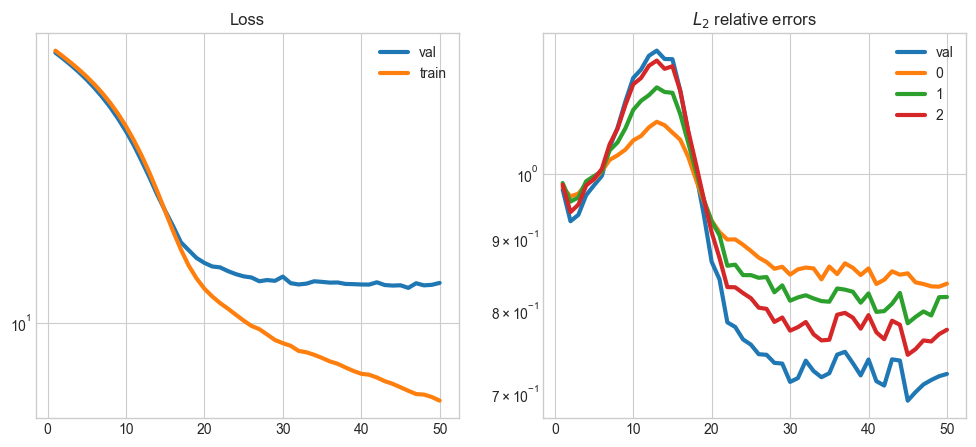

In [241]:
metrics = pd.read_csv("%s/%s/csv/metrics.csv"%(save_dir,name))
metrics
metrics_train = metrics.iloc[~np.isnan(metrics["train_loss"].values)]
metrics_val = metrics.iloc[~np.isnan(metrics["val_loss"].values)]
metrics
parsed_metrics = {
    "train_loss": metrics_train["train_loss"].values,
    "val_loss": metrics_val["val_loss"].values,
    "val_mean_l2rerror": metrics_val["val_mean_l2rerror"].values,
}
for k in range(maxiter):
    parsed_metrics["val_mean_l2rerror_%d"%k] = metrics_val["val_mean_l2rerror_%d"%k].values
metrics = pd.DataFrame(parsed_metrics)
metrics.index = metrics.index+1
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(12,5))
ax[0].set_title(r"Loss")
ax[0].plot(metrics.index,metrics["val_loss"],label="val",linewidth=LW)
ax[0].plot(metrics.index,metrics["train_loss"],label="train",linewidth=LW)
ax[0].legend()
ax[0].set_yscale("log",base=10)
ax[1].set_title(r"$L_2$ relative errors")
ax[1].plot(metrics.index,metrics["val_mean_l2rerror"],label="val",linewidth=LW)
for k in range(3):#maxiter):
    ax[1].plot(metrics.index,metrics["val_mean_l2rerror_%d"%k],label=k,linewidth=LW)#,color="k",alpha=(maxiter-k)/maxiter)
ax[1].legend()
ax[1].set_yscale("log",base=10)
metrics.iloc[::max(1,len(metrics)//10)]

/var/folders/rz/_ktvltjs49v_z33w0h6njx5w0000gn/T/ipykernel_65515/2522163826.py:12
/var/folders/rz/_ktvltjs49v_z33w0h6njx5w0000gn/T/ipykernel_65515/2522163826.py:24


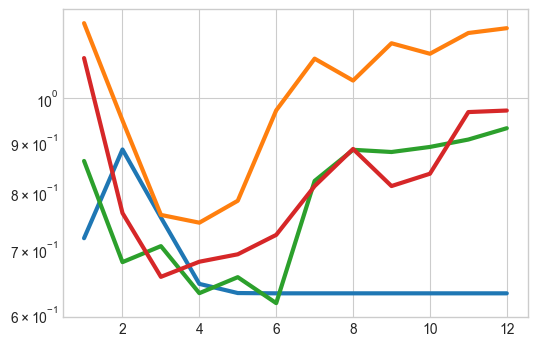

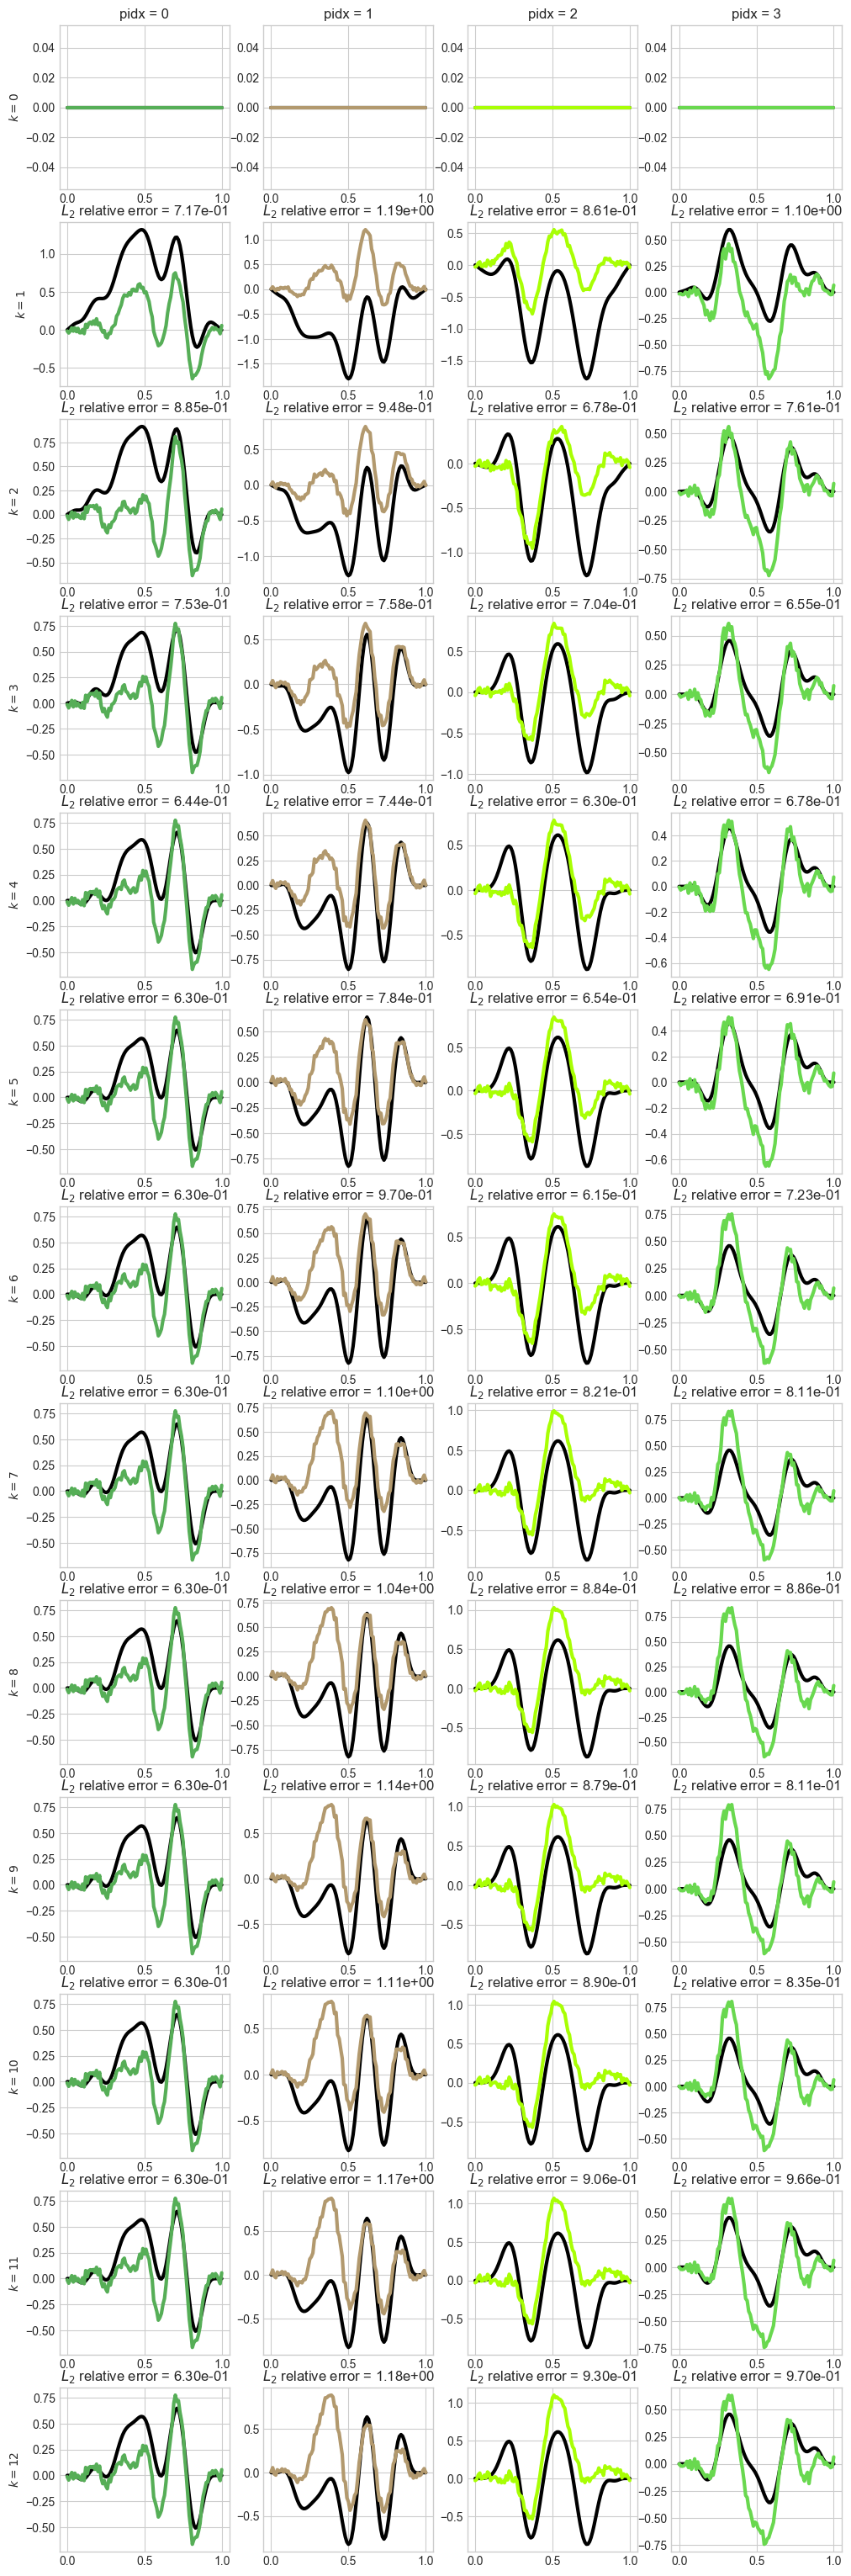

In [242]:
pidxs = [0,1,2,3]
ncols = len(pidxs)
nrows = maxiter+1
vhat = torch.zeros((ncols,nrows,ki.length))
for k in range(nrows-1):
    with torch.inference_mode(True):
        vhat[:,k+1,:] = mlp(torch.hstack([uticks_val[pidxs,:],vhat[:,k,:]]))
l2rerrors = torch.linalg.norm(vhat[:,:,:nxticks]-vopt_val[pidxs,:,:nxticks],dim=2)/torch.linalg.norm(vopt_val[pidxs,:,:nxticks],dim=2)
fig,ax = pyplot.subplots(nrows=1,ncols=1,figsize=((6,4)))
ax.plot(torch.arange(nrows),l2rerrors.T,linewidth=LW)
ax.set_yscale("log",base=10)
fig.show()
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(3*ncols,3*nrows))
for i in range(ncols):
    for k in range(nrows):
        ax[k,i].plot(xticks,vopt_val[pidxs[i],k,:nxticks],linewidth=LW,color="k")
        ax[k,i].plot(xticks,vhat[pidxs[i],k,:nxticks],linewidth=LW,color=COLORS[i])
        if k>0:
            ax[k,i].set_title(r"$L_2$ relative error = %.2e"%l2rerrors[i,k])
for i in range(ncols):
    ax[0,i].set_title("pidx = %d"%pidxs[i])
for k in range(nrows):
    ax[k,0].set_ylabel(r"$k = %d$"%k)
fig.show()

### DeepONet

In [227]:
class DeepONet(torch.nn.Module):
    def __init__(self, branches_layers_nodes:list, trunks_layers_nodes:list, branch_activation_function:torch.nn.Module=torch.nn.Tanh(), trunk_activation_function:torch.nn.Module=torch.nn.Tanh(), scale_last_layer:bool=True, bias_last_layer:bool=True, weight_init_scheme:callable=None):
        super().__init__()
        self.branches_layers_nodes,self.trunks_layers_nodes = branches_layers_nodes,trunks_layers_nodes
        self.n_branches,self.n_trunks = len(branches_layers_nodes),len(trunks_layers_nodes)
        self.combining_neurons = trunks_layers_nodes[0][-1]
        self.output_nodes = branches_layers_nodes[0][-1]/self.combining_neurons
        assert self.output_nodes%1==0; self.output_nodes = int(self.output_nodes)
        assert all(branches_layers_nodes[i][-1]==(self.output_nodes*self.combining_neurons) for i in range(self.n_branches)), "Each branch net must have the same number of outputs"
        assert all(trunks_layers_nodes[i][-1]==self.combining_neurons for i in range(self.n_trunks)), "Each trunk net must have the same number of outputs as each branch net"
        self.branch_nets = torch.nn.ModuleList([MultilayerPerceptron(branches_layers_nodes[i],activation_function=branch_activation_function,activate_last_layer=False,scale_last_layer=False,bias_last_layer=False,weight_init_scheme=weight_init_scheme) for i in range(self.n_branches)])
        self.trunk_nets = torch.nn.ModuleList([MultilayerPerceptron(trunks_layers_nodes[i],activation_function=trunk_activation_function,activate_last_layer=True,scale_last_layer=False,bias_last_layer=False,weight_init_scheme=weight_init_scheme) for i in range(self.n_trunks)])
        self.logscale,self.bias = torch.tensor(0.),torch.tensor(0.)
        if scale_last_layer: self.logscale = torch.nn.parameter.Parameter(self.logscale)
        if bias_last_layer: self.bias = torch.nn.parameter.Parameter(self.bias)
    def output_transform(self, x:torch.Tensor):
        return x
    def _forward_branch_nets(self, x_branches:List[torch.Tensor]):
        assert len(x_branches)==self.n_branches
        y_branches_prod = 1.
        for i,branch_net in enumerate(self.branch_nets):
            y_branches_prod *= branch_net(x_branches[i])
        return y_branches_prod
    def _forward_trunck_nets(self, x_trunks:List[torch.Tensor]):
        assert len(x_trunks)==self.n_trunks
        y_trunks_prod = 1.
        for i,trunk_net in enumerate(self.trunk_nets):
            y_trunks_prod *= trunk_net(x_trunks[i])
        return y_trunks_prod
    def _forward_combine(self, y_branches_prod, y_trunks_prod):
        out = (y_branches_prod.reshape(-1,self.combining_neurons,self.output_nodes)*y_trunks_prod.reshape(-1,self.combining_neurons,1)).sum(1).squeeze()
        out_tf = self.output_transform(out)
        out = torch.exp(self.logscale)*out_tf+self.bias
        return out
    def forward(self, x_branches:List[torch.Tensor], x_trunks:List[torch.Tensor]):
        y_branches_prod = self._forward_branch_nets(x_branches)
        y_trunks_prod = self._forward_trunck_nets(x_trunks)
        out = self._forward_combine(y_branches_prod,y_trunks_prod)
        return out

#### Interior only

In [ ]:
class DatasetDeepONeti(torch.utils.data.Dataset):
    def __init__(self, u, v, xs, device="cpu"):
        self.u = u.to(torch.float32)
        self.vi = v[:,:,:nxticks].to(torch.float32)
        # could automatically construct x,beta if given ki
        self.x = xs[0][:,0].to(torch.float32)
        self.i_r,self.i_k,self.i_q = torch.cartesian_prod(torch.arange(self.u.size(0)),torch.arange(self.vi.size(1)-1),torch.arange(self.x.size(0))).T
        self._put_on_device(device)
    def __getitems__(self, i):
        i = torch.tensor(i,dtype=torch.int)
        ir,ik,iq = self.i_r[i],self.i_k[i],self.i_q[i]
        return self.u[ir],self.vi[ir,ik,:],self.x[iq],self.vi[ir,ik+1,iq]
    def __len__(self):
        return len(self.i_r)
    def _put_on_device(self, device):
        self.i_r,self.i_k,self.i_q = self.i_r.to(device),self.i_k.to(device),self.i_q.to(device)
        self.u,self.vi,self.x = self.u.to(device),self.vi.to(device),self.x.to(device)
class DeepONetLightningi(lightning.LightningModule):
    def __init__(self, don, automatic_optimization=True):
        super().__init__()
        self.don = don
        self.automatic_optimization = automatic_optimization
    def _common_step(self, batch, tag):
        u,vi,x,vinext = batch
        vinext_hat = self.don(x_branches=[u,vi],x_trunks=[x[:,None]])
        loss = torch.nn.functional.l1_loss(vinext_hat,vinext)
        if tag=="val":
            vinext_hat_r,vinext_r = vinext_hat.reshape((-1,nxticks)),vinext.reshape((-1,nxticks))
            mean_l2rerror = torch.mean(torch.linalg.norm(vinext_hat_r-vinext_r,dim=1)/torch.linalg.norm(vinext_r,dim=1))
        self.log(tag+"_loss",loss,prog_bar=tag!="val",logger=True,sync_dist=True,on_step=False,on_epoch=True)
        if tag=="val":
            self.log(tag+"_mean_l2rerror",mean_l2rerror,prog_bar=tag!="val",logger=True,sync_dist=True,on_step=False,on_epoch=True)
        return loss
    def training_step(self, batch, batch_idx):
        if self.automatic_optimization:
            return self._common_step(batch,tag="train")
        else:
            opt = self.optimizers()
            def closure():
                loss = self._common_step(batch,tag="train")
                opt.zero_grad(set_to_none=True)
                self.manual_backward(loss)
                return loss
            opt.step(closure=closure)
    def validation_step(self, batch, batch_idx):
        with torch.inference_mode(True):
          return self._common_step(batch,tag="val")
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),lr=5e-3,amsgrad=True)
        return optimizer

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
save_dir = "DeepONet_i"
name = "DeepONet_i_small"
don = DeepONet(
    branches_layers_nodes = [[nxticks,32,32],[nxticks,32,32]],
    trunks_layers_nodes = [[1,32,32,32]],
    branch_activation_function = torch.nn.ReLU(),
    trunk_activation_function = torch.nn.GELU(),
    scale_last_layer = True,
    bias_last_layer = True,
    weight_init_scheme = None,
    )
don_lightning = DeepONetLightningi(don)
don_lightning.to(DEVICE)
dataset_don_train = DatasetDeepONeti(uticks_train,vopt_train,xs,device=DEVICE)
dataset_don_val = DatasetDeepONeti(uticks_val,vopt_val,xs,device=DEVICE)
print("number train: %.1e"%len(dataset_don_train))
print("number val  : %.1e"%len(dataset_don_val))
def batched_collate_fn(batch):
    return tuple(batch)
dataloader_don_train = torch.utils.data.DataLoader(dataset_don_train,batch_size=2**9,collate_fn=batched_collate_fn,shuffle=True)
dataloader_don_val = torch.utils.data.DataLoader(dataset_don_val,batch_size=len(dataset_don_val),collate_fn=batched_collate_fn,shuffle=False)
csv_logger = lightning.pytorch.loggers.CSVLogger(save_dir=save_dir,name=name,version='csv')
trainer = lightning.Trainer(
    max_epochs = 10,
    logger = [csv_logger],
    #limit_train_batches=2**10,
    #log_every_n_steps = 1e10,
    enable_progress_bar = True,
    #num_sanity_val_steps = 0,
    gradient_clip_val = 0.,
    gradient_clip_algorithm = "norm",
  )
trainer.fit(model=don_lightning, train_dataloaders=dataloader_don_train, val_dataloaders=dataloader_don_val)

In [ ]:
metrics = pd.read_csv("%s/%s/csv/metrics.csv"%(save_dir,name))
metrics_train = metrics.iloc[~np.isnan(metrics["train_loss"].values)]
metrics_val = metrics.iloc[~np.isnan(metrics["val_loss"].values)]
metrics = pd.DataFrame({
    "train_loss": metrics_train["train_loss"].values,
    "val_loss": metrics_val["val_loss"].values,
    #"train_mean_l2rerror": metrics_train["train_mean_l2rerror"].values,
    "val_mean_l2rerror": metrics_val["val_mean_l2rerror"].values,})
metrics.index = metrics.index+1
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(12,5))
ax[0].set_title(r"Loss")
ax[0].plot(metrics.index,metrics["val_loss"],label="val")
ax[0].plot(metrics.index,metrics["train_loss"],label="train")
ax[0].legend()
ax[0].set_yscale("log",base=10)
ax[1].set_title(r"$L_2$ relative errors")
# ax[1].plot(metrics.index,metrics["train_mean_l2rerror"],label="train")
ax[1].plot(metrics.index,metrics["val_mean_l2rerror"],label="val")
ax[1].legend()
ax[1].set_yscale("log",base=10)
metrics.iloc[::max(1,len(metrics)//10)]

#### Full

In [248]:
class DatasetDeepONet(torch.utils.data.Dataset):
    def __init__(self, u, v, xs, device="cpu"):
        self.u = u.to(torch.float64)
        self.v = v.to(torch.float64)
        # could automatically construct x,beta if given ki
        self.x = torch.hstack([xs[0][:,0],xs[0][:,0],xs[1][:,0]]).to(torch.float64)
        self.beta = torch.hstack([torch.zeros(nxticks,dtype=int),2*torch.ones(nxticks,dtype=int),torch.zeros(2,dtype=int)])
        self.i_r,self.i_k,self.i_q = torch.cartesian_prod(torch.arange(u.size(0)),torch.arange(v.size(1)-1),torch.arange(self.x.size(0))).T
        self._put_on_device(device)
    def __getitems__(self, i):
        i = torch.tensor(i,dtype=torch.int)
        ir,ik,iq = self.i_r[i],self.i_k[i],self.i_q[i]
        return self.u[ir],self.v[ir,ik,:],self.x[iq],self.beta[iq],self.v[ir,ik+1,iq]
    def __len__(self):
        return len(self.i_r)
    def _put_on_device(self, device):
        self.i_r,self.i_k,self.i_q = self.i_r.to(device),self.i_k.to(device),self.i_q.to(device)
        self.u,self.v,self.x,self.beta = self.u.to(device),self.v.to(device),self.x.to(device),self.beta.to(device)
class DeepONetLightning(lightning.LightningModule):
    def __init__(self, don, automatic_optimization=True):
        super().__init__()
        self.don = don
        self.automatic_optimization = automatic_optimization
    def _common_step(self, batch, tag):
        u,v,x,beta,vnext = batch
        x.requires_grad_()
        vnext_hat = self.don(x_branches=[u,v],x_trunks=[x[:,None]])
        lap_flag = beta==2
        grad_vnext_hat = torch.autograd.grad(vnext_hat,x,grad_outputs=torch.ones_like(x).to(self.device),create_graph=True,retain_graph=True)[0]
        lap_vnext = torch.autograd.grad(grad_vnext_hat,x,grad_outputs=torch.ones_like(x).to(self.device),create_graph=True,retain_graph=True)[0]
        vnext_hat_full = torch.ones_like(vnext_hat)
        vnext_hat_full[~lap_flag] = vnext_hat[~lap_flag]
        vnext_hat_full[lap_flag] = lap_vnext[lap_flag]
        if tag=="val":
            vnext_hat_r,vnext_r = vnext_hat.reshape((-1,ki.length))[:,:nxticks],vnext.reshape((-1,ki.length))[:,:nxticks]
            mean_l2rerror = torch.mean(torch.linalg.norm(vnext_hat_r-vnext_r,dim=1)/torch.linalg.norm(vnext_r,dim=1))
            self.log(tag+"_mean_l2rerror",mean_l2rerror,prog_bar=tag!="val",logger=True,sync_dist=True,on_step=False,on_epoch=True)
        loss = torch.sqrt(torch.nn.functional.mse_loss(vnext_hat_full,vnext))
        #loss = torch.nn.functional.l1_loss(vnextf_hat,vnext)
        self.log(tag+"_loss",loss,prog_bar=tag!="val",logger=True,sync_dist=True,on_step=False,on_epoch=True)
        return loss
    def training_step(self, batch, batch_idx):
        if self.automatic_optimization:
            return self._common_step(batch,tag="train")
        else:
            opt = self.optimizers()
            def closure():
                loss = self._common_step(batch,tag="train")
                opt.zero_grad(set_to_none=True)
                self.manual_backward(loss)
                return loss
            opt.step(closure=closure)
    def validation_step(self, batch, batch_idx):
        with torch.inference_mode(True):
            return self._common_step(batch,tag="val")
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),lr=1e-3,amsgrad=True)
        return optimizer

In [249]:
import gc
gc.collect()
torch.cuda.empty_cache()
save_dir = "DeepONet"
name = "DeepONet_small"
don = DeepONet(
    branches_layers_nodes = [[nxticks,128,128],[ki.length,128,128]],
    trunks_layers_nodes = [[1,128,128,128]],
    branch_activation_function = torch.nn.Sigmoid(),
    trunk_activation_function = torch.nn.Tanh(),
    scale_last_layer = True,
    bias_last_layer = True,
    weight_init_scheme = torch.nn.init.kaiming_normal_,
    )
don_lightning = DeepONetLightning(don)
don_lightning.to("cpu")
don_lightning.to(torch.float64)
dataset_don_train = DatasetDeepONet(uticks_train,vopt_train,xs,device="cpu")
dataset_don_val = DatasetDeepONet(uticks_val,vopt_val,xs,device="cpu")
print("number train: %.1e"%len(dataset_don_train))
print("number val  : %.1e"%len(dataset_don_val))
def batched_collate_fn(batch):
    return tuple(batch)
dataloader_don_train = torch.utils.data.DataLoader(dataset_don_train,batch_size=2**12,collate_fn=batched_collate_fn,shuffle=True)
dataloader_don_val = torch.utils.data.DataLoader(dataset_don_val,batch_size=len(dataset_don_val),collate_fn=batched_collate_fn,shuffle=False)
csv_logger = lightning.pytorch.loggers.CSVLogger(save_dir=save_dir,name=name,version='csv')
trainer = lightning.Trainer(
    max_epochs = 10,
    logger = [csv_logger],
    #limit_train_batches=2**10,
    #log_every_n_steps = 1e10,
    enable_progress_bar = True,
    num_sanity_val_steps = 0,
    gradient_clip_val = 1.,
    gradient_clip_algorithm = "value",
    #detect_anomaly = True,
  )
trainer.fit(model=don_lightning, train_dataloaders=dataloader_don_train, val_dataloaders=dataloader_don_val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory DeepONet/DeepONet_small/csv exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory DeepONet/DeepONet_small/csv/checkpoints exists and is not empty.

  | Name | Type     | Params | Mode 
------------------------------------------
0 | don  | DeepONet | 105 K  | train
------------------------------------------
105 K     Trainable params
0         Non-trainable params
105 K     Total params
0.422     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


number train: 2.2e+06
number val  : 3.1e+05


/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                                              | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
metrics = pd.read_csv("%s/%s/csv/metrics.csv"%(save_dir,name))
metrics_train = metrics.iloc[~np.isnan(metrics["train_loss"].values)]
metrics_val = metrics.iloc[~np.isnan(metrics["val_loss"].values)]
metrics = pd.DataFrame({
    "train_loss": metrics_train["train_loss"].values,
    "val_loss": metrics_val["val_loss"].values,
    "val_mean_l2rerror": metrics_val["val_mean_l2rerror"].values,
})
metrics.index = metrics.index+1
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(12,5))
ax[0].set_title(r"Loss")
ax[0].plot(metrics.index,metrics["val_loss"],label="val")
ax[0].plot(metrics.index,metrics["train_loss"],label="train")
ax[0].legend()
ax[0].set_yscale("log",base=10)
ax[1].set_title(r"$L_2$ relative errors")
ax[1].plot(metrics.index,metrics["val_mean_l2rerror"],label="val")
ax[1].legend()
ax[1].set_yscale("log",base=10)
metrics.iloc[::max(1,len(metrics)//10)]

## Inference